# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t120.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index Condition  99.466474  103.977689  108.486724  112.991457  \
0                91     C1_R1     8862.0      9434.0      9463.0      8940.0   
1                92     C1_R1     8473.0      9471.0      9488.0      9014.0   
2                93     C1_R1     8700.0      9357.0      9703.0      8901.0   
3                94     C1_R1     8760.0      9131.0      9566.0      8996.0   
4                95     C1_R1     8579.0      9359.0      9611.0      9183.0   
..              ...       ...        ...         ...         ...         ...   
175            1104    C10_R3     7365.0      8167.0      8169.0      7951.0   
176            1105    C10_R3     7535.0      7877.0      8147.0      7872.0   
177            1106    C10_R3     7574.0      7891.0      8365.0      8068.0   
178            1107    C10_R3     7282.0      8168.0      8299.0      7962.0   
179            1108    C10_R3     7541.0      8273.0      8222.0      7905.0   

     117.494015  121.994401  126.490494  130.982299  ...  2470.127521  \
0        8046.0      7560.0      6535.0      5880.0  ...        138.0   
1        8129.0      7372.0      6619.0      5891.0  ...        105.0   
2        8187.0      7381.0      6661.0      5979.0  ...         74.0   
3        8178.0      7358.0      6592.0      6201.0  ...        109.0   
4        8067.0      7335.0      6469.0      6073.0  ...        145.0   
..          ...         ...         ...         ...  ...          ...   
175      7309.0      6597.0      5853.0      5369.0  ...        150.0   
176      7283.0      6632.0      6065.0      5520.0  ...        150.0   
177      7231.0      6674.0      5895.0      5459.0  ...         95.0   
178      7319.0      6688.0      6015.0      5499.0  ...        112.0   
179      7467.0      6779.0      6069.0      5566.0  ...        174.0   

     2473.292006  2476.455263  2479.615672  2482.776474  2485.936050  \
0          117.0        157.0        173.0         99.0        174.0   
1           63.0        193.0         95.0        174.0        162.0   
2           96.0        178.0        142.0        108.0        140.0   
3          125.0        159.0        175.0        159.0        154.0   
4          148.0        197.0        167.0        129.0        108.0   
..           ...          ...          ...          ...          ...   
175        152.0        166.0        137.0        140.0        183.0   
176        109.0        144.0        208.0        155.0        109.0   
177        113.0        193.0        143.0        120.0        110.0   
178         87.0        202.0        102.0        185.0        121.0   
179        108.0        127.0        206.0        123.0        108.0   

     2489.092782  2492.249908  2495.404193  2498.554024  
0          149.0        145.0        129.0        190.0  
1          169.0        144.0        151.0        152.0  
2          135.0        150.0        182.0        163.0  
3          177.0         77.0        194.0        113.0  
4          154.0        150.0        149.0        157.0  
..           ...          ...          ...          ...  
175        166.0        111.0        162.0        156.0  
176        139.0        130.0        177.0        105.0  
177        152.0        143.0        153.0        186.0  
178        172.0        136.0        184.0        149.0  
179        172.0        110.0        153.0        132.0  

[180 rows x 638 columns]

# Test Plots and Baseline Correction

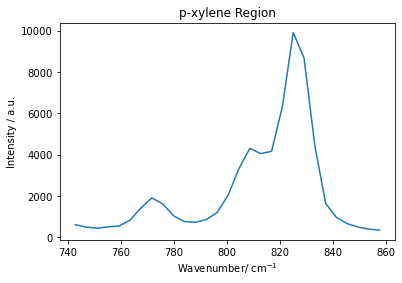

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

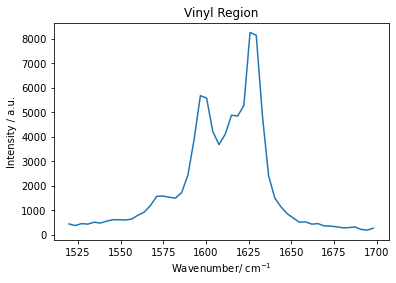

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

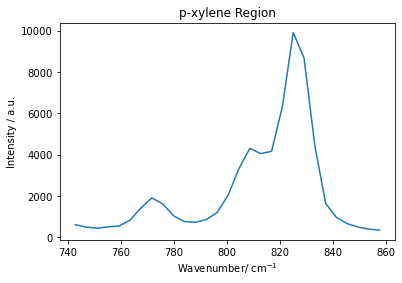

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.834292, 607.0),
 (746.962667, 492.0),
 (751.091134, 438.0),
 (755.21771, 504.0),
 (759.340416, 547.0),
 (845.377537, 660.0),
 (849.447323, 496.0),
 (853.515262, 393.0),
 (857.581354, 347.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

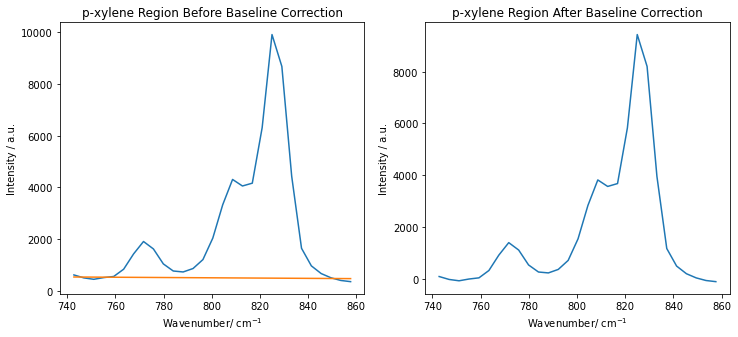

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

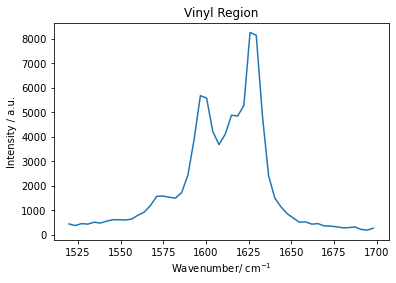

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.755023, 442.0),
 (1523.442667, 374.0),
 (1527.12692, 453.0),
 (1530.809599, 433.0),
 (1534.490706, 510.0),
 (1538.168428, 477.0),
 (1541.846393, 554.0),
 (1545.520977, 611.0),
 (1549.192184, 613.0),
 (1552.863636, 599.0),
 (1665.628682, 454.0),
 (1669.234594, 358.0),
 (1672.837202, 352.0),
 (1676.440075, 326.0),
 (1680.037865, 284.0),
 (1683.635922, 288.0),
 (1687.230684, 319.0),
 (1690.823934, 217.0),
 (1694.415672, 188.0),
 (1698.005899, 266.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

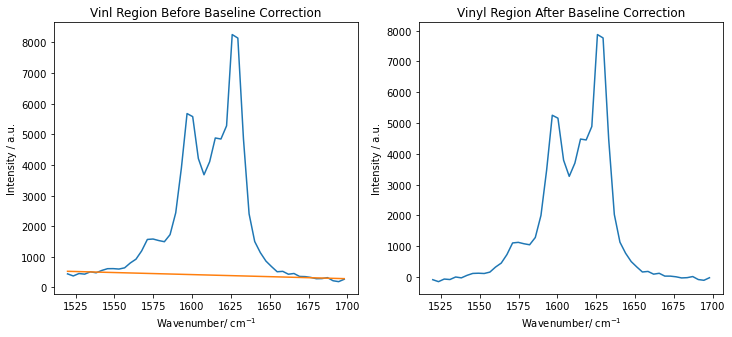

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.755023  1523.442667  1527.126920  1530.809599  1534.490706  \
0          442.0        374.0        453.0        433.0        510.0   
1          481.0        421.0        456.0        406.0        519.0   
2          414.0        375.0        468.0        474.0        516.0   
3          416.0        422.0        463.0        378.0        465.0   
4          463.0        397.0        424.0        440.0        515.0   
..           ...          ...          ...          ...          ...   
175        378.0        376.0        430.0        443.0        468.0   
176        336.0        298.0        407.0        475.0        457.0   
177        377.0        384.0        338.0        426.0        464.0   
178        426.0        417.0        385.0        451.0        465.0   
179        432.0        390.0        413.0        388.0        439.0   

     1538.168428  1541.846393  1545.520977  1549.192184  1552.863636  ...  \
0          477.0        554.0        611.0        613.0        599.0  ...   
1          487.0        602.0        599.0        612.0        648.0  ...   
2          458.0        539.0        645.0        620.0        585.0  ...   
3          521.0        570.0        545.0        582.0        592.0  ...   
4          500.0        535.0        607.0        592.0        652.0  ...   
..           ...          ...          ...          ...          ...  ...   
175        537.0        496.0        585.0        649.0        628.0  ...   
176        494.0        542.0        544.0        602.0        596.0  ...   
177        567.0        542.0        572.0        576.0        640.0  ...   
178        516.0        472.0        586.0        606.0        611.0  ...   
179        474.0        584.0        625.0        686.0        628.0  ...   

     1665.628682  1669.234594  1672.837202  1676.440075  1680.037865  \
0          454.0        358.0        352.0        326.0        284.0   
1          429.0        361.0        311.0        320.0        307.0   
2          448.0        381.0        316.0        293.0        291.0   
3          408.0        340.0        290.0        302.0        266.0   
4          440.0        390.0        381.0        314.0        270.0   
..           ...          ...          ...          ...          ...   
175        451.0        434.0        328.0        362.0        283.0   
176        401.0        393.0        368.0        355.0        333.0   
177        499.0        398.0        395.0        388.0        314.0   
178        445.0        405.0        391.0        342.0        316.0   
179        484.0        399.0        423.0        378.0        342.0   

     1683.635922  1687.230684  1690.823934  1694.415672  1698.005899  
0          288.0        319.0        217.0        188.0        266.0  
1          274.0        296.0        193.0        236.0        244.0  
2          263.0        289.0        269.0        232.0        230.0  
3          284.0        323.0        189.0        184.0        250.0  
4          347.0        293.0        244.0        245.0        242.0  
..           ...          ...          ...          ...          ...  
175        352.0        309.0        286.0        277.0        257.0  
176        317.0        271.0        252.0        297.0        240.0  
177        312.0        348.0        306.0        300.0        237.0  
178        358.0        327.0        263.0        246.0        261.0  
179        305.0        350.0        238.0        276.0        283.0  

[180 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 160000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 8

ampL2 = 200000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

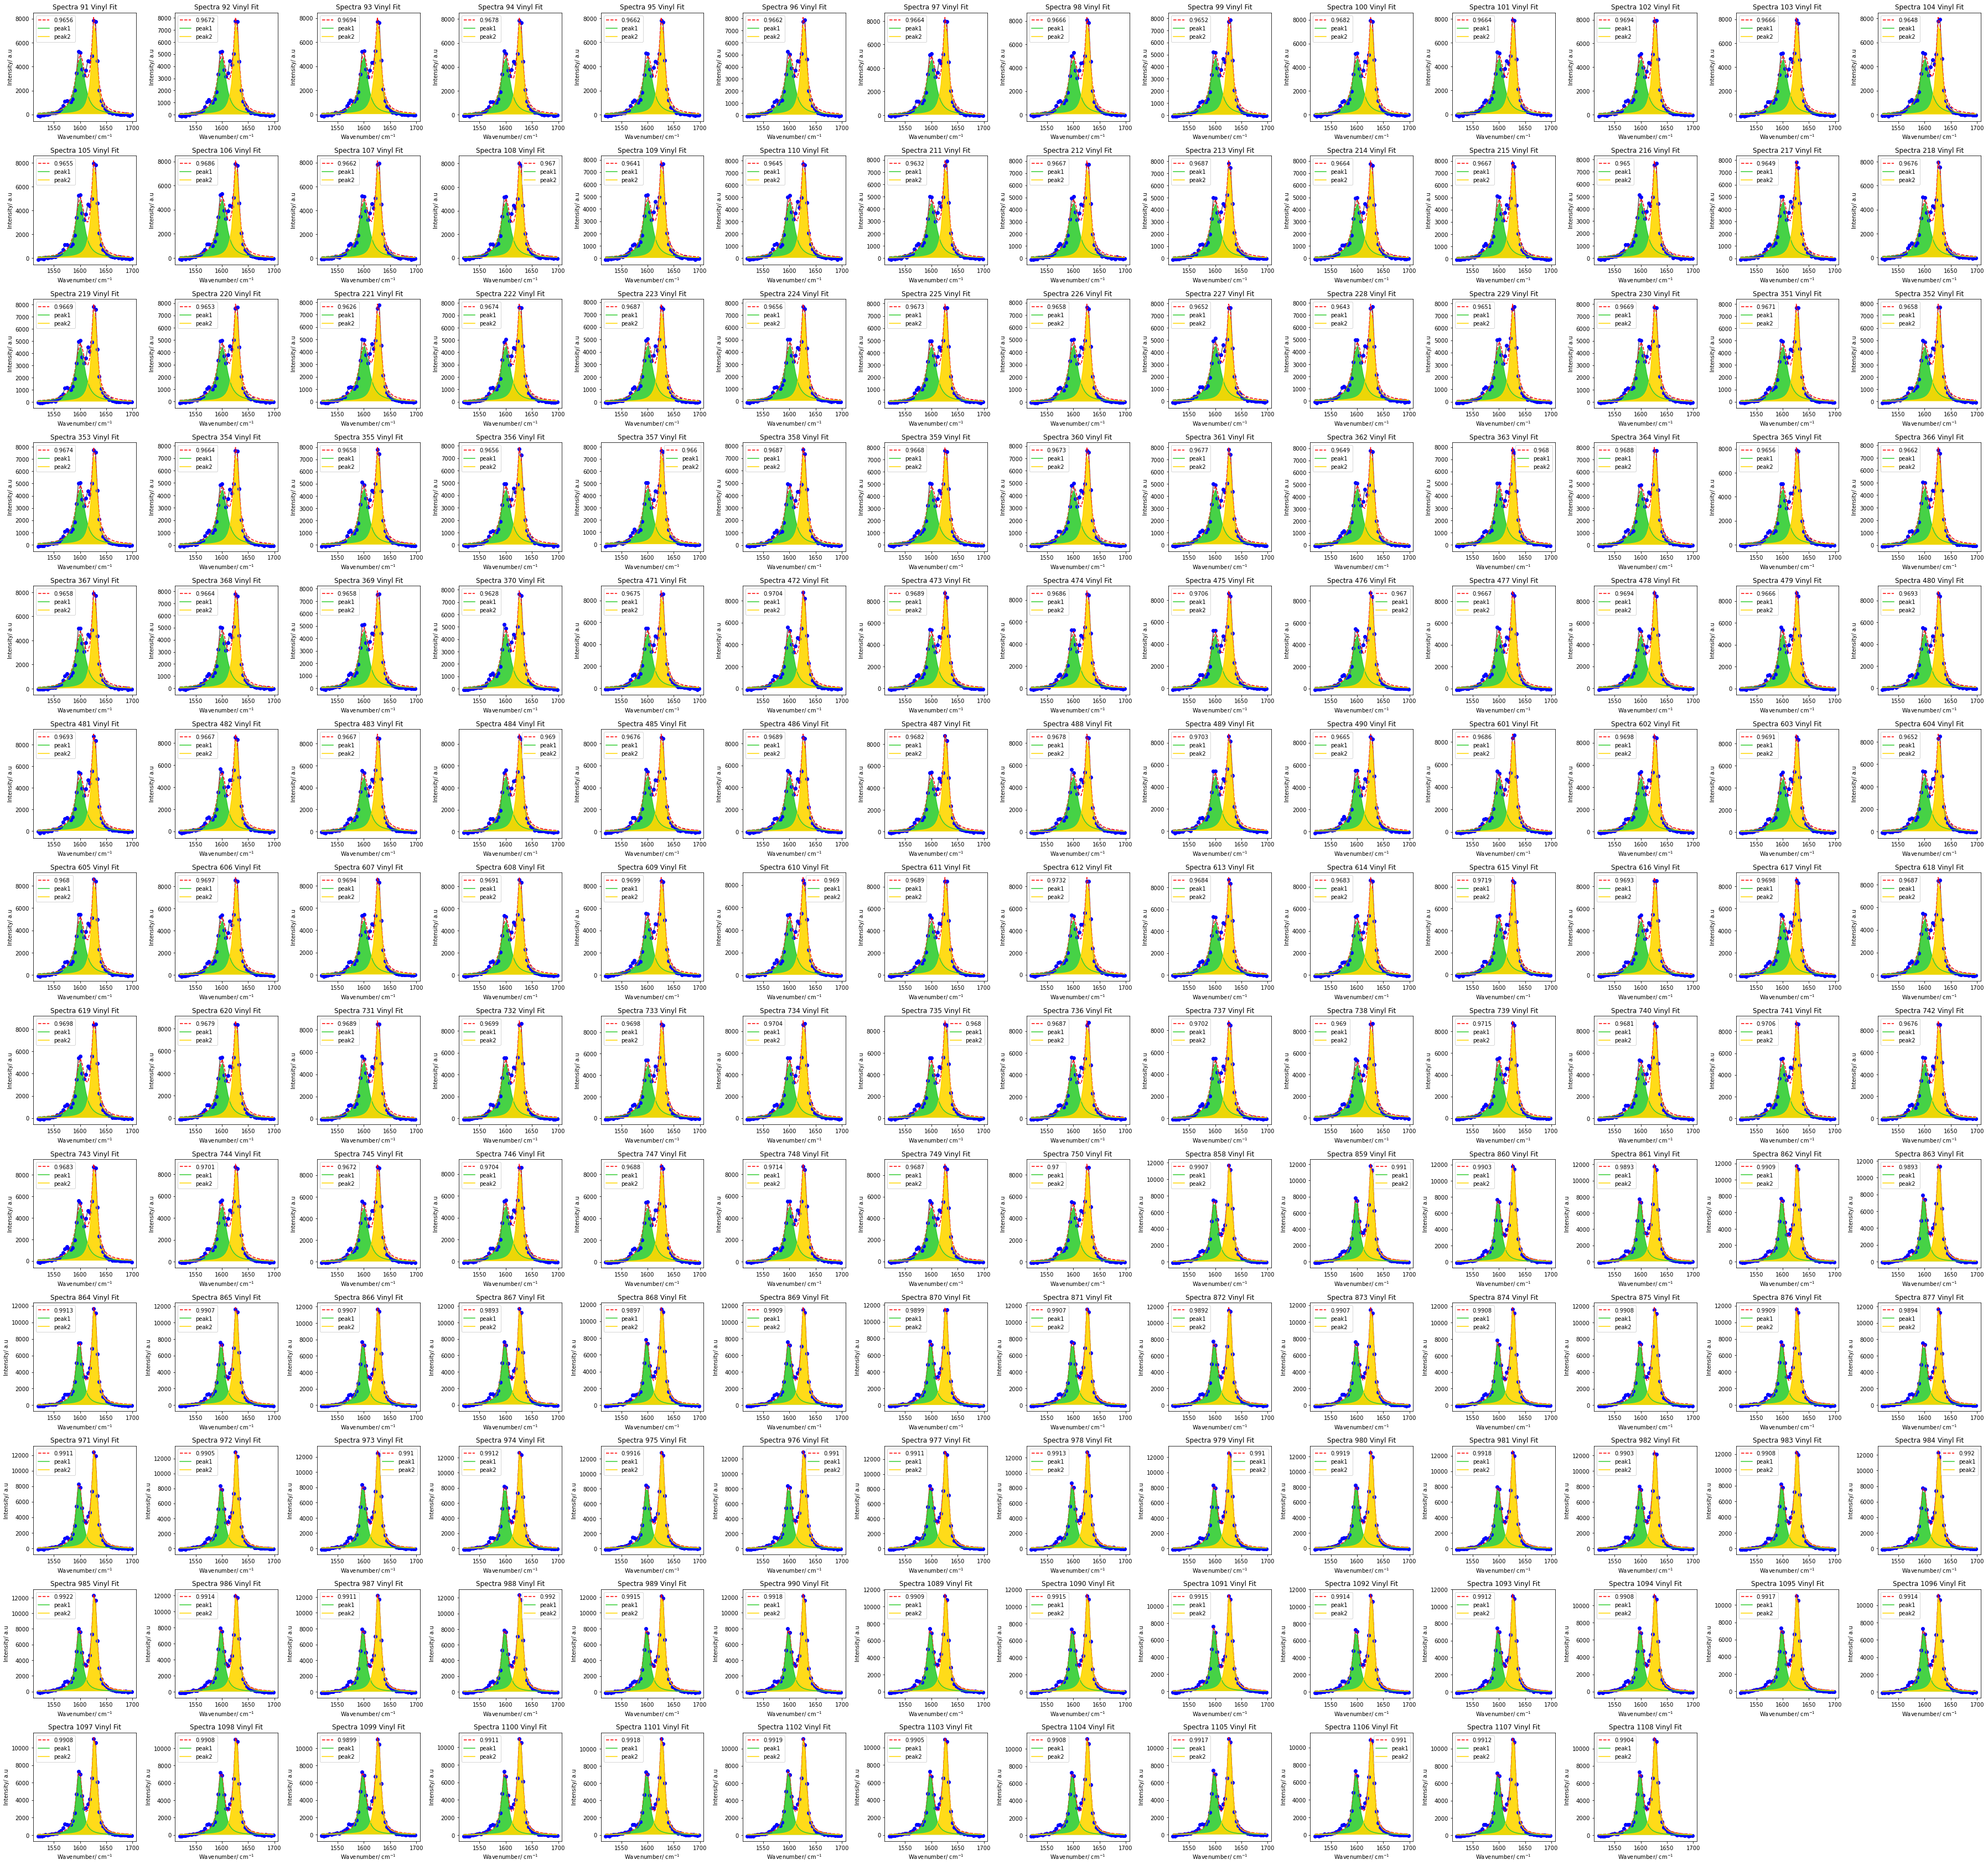

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(int(np.ceil(np.sqrt(df_vinyl.shape[0]))),int(np.ceil(np.sqrt(df_vinyl.shape[0]))),(1+i))
    # int() prior to np.ceil was added because subplots no longer accept any other data type except for int.
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     180.000000     180.000000   180.000000   180.000000  180.000000   
mean   157976.946815  171537.579264  1599.587888  1627.251808    9.309074   
std      7867.141766   27962.353628     0.901252     0.112919    1.693829   
min    140494.030886  137950.218918  1598.121366  1626.937947    6.702196   
25%    153262.328560  146813.623559  1598.413408  1627.173428    7.057372   
50%    156106.886742  161880.701901  1600.010637  1627.242767   10.192429   
75%    161625.816887  197736.051520  1600.286893  1627.347890   10.633713   
max    182972.039173  229234.323534  1600.832497  1627.451293   11.429908   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  180.000000  180.000000  180.000000  180.000000   180.000000   
mean     5.756846    0.975412   18.618149   11.513692  5642.603811   
std      0.309986    0.011127    3.387659    0.619972  1361.855093   
min      5.185031    0.962590   13.404393   10.370063  4354.200548   
25%      5.380883    0.966856   14.114744   10.761766  4598.645470   
50%      5.880815    0.968977   20.384859   11.761629  4892.271005   
75%      5.996822    0.990711   21.267426   11.993645  7175.726173   
max      6.386856    0.992210   22.859815   12.773712  8362.104316   

          Height_L2  
count    180.000000  
mean    9586.456618  
std     2076.895299  
min     7463.138977  
25%     7799.235399  
50%     8622.650163  
75%    11825.755953  
max    13771.195600

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index Condition  Vinyl Peak Area  R2_Vinyl
0                91     C1_R1    138587.547652  0.965637
1                92     C1_R1    141260.120642  0.967180
2                93     C1_R1    147813.740481  0.969402
3                94     C1_R1    142101.268120  0.967807
4                95     C1_R1    138929.524392  0.966163
..              ...       ...              ...       ...
175            1104    C10_R3    187700.592128  0.990751
176            1105    C10_R3    189697.713225  0.991691
177            1106    C10_R3    188225.767867  0.991016
178            1107    C10_R3    187189.265204  0.991182
179            1108    C10_R3    190395.598963  0.990436

[180 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.834292  746.962667  751.091134  755.217710  759.340416  763.461235  \
0         607.0       492.0       438.0       504.0       547.0       828.0   
1         543.0       486.0       413.0       480.0       512.0       741.0   
2         603.0       518.0       439.0       419.0       579.0       798.0   
3         612.0       471.0       454.0       485.0       510.0       819.0   
4         552.0       444.0       453.0       506.0       563.0       794.0   
..          ...         ...         ...         ...         ...         ...   
175       583.0       613.0       513.0       612.0       639.0       919.0   
176       609.0       530.0       454.0       500.0       689.0       983.0   
177       552.0       516.0       473.0       492.0       653.0       973.0   
178       590.0       514.0       548.0       509.0       677.0       986.0   
179       585.0       516.0       502.0       542.0       618.0      1029.0   

     767.580170  771.695243  775.808435  779.919748  ...  820.902250  \
0        1420.0      1901.0      1613.0      1034.0  ...      6308.0   
1        1354.0      2050.0      1729.0      1005.0  ...      6393.0   
2        1420.0      1880.0      1693.0      1144.0  ...      6270.0   
3        1389.0      1972.0      1756.0      1044.0  ...      6486.0   
4        1371.0      2030.0      1726.0      1049.0  ...      6589.0   
..          ...         ...         ...         ...  ...         ...   
175      1880.0      2522.0      2062.0      1211.0  ...      2906.0   
176      1881.0      2752.0      2090.0      1287.0  ...      3019.0   
177      1862.0      2762.0      2167.0      1226.0  ...      2946.0   
178      1862.0      2691.0      2130.0      1197.0  ...      2833.0   
179      1842.0      2569.0      2198.0      1275.0  ...      3020.0   

     824.985123  829.068103  833.149225  837.228491  841.303940  845.377537  \
0        9912.0      8678.0      4428.0      1638.0       958.0       660.0   
1        9885.0      8937.0      4543.0      1779.0       855.0       690.0   
2       10010.0      8940.0      4499.0      1737.0       864.0       616.0   
3        9948.0      9044.0      4412.0      1768.0       950.0       657.0   
4        9901.0      8927.0      4637.0      1725.0       939.0       614.0   
..          ...         ...         ...         ...         ...         ...   
175      4270.0      3723.0      2111.0      1016.0       567.0       495.0   
176      4396.0      3866.0      2007.0       875.0       581.0       487.0   
177      4327.0      3847.0      1994.0      1061.0       605.0       561.0   
178      4300.0      3927.0      2138.0      1049.0       643.0       491.0   
179      4495.0      3945.0      2138.0      1110.0       588.0       520.0   

     849.447323  853.515262  857.581354  
0         496.0       393.0       347.0  
1         484.0       395.0       310.0  
2         465.0       363.0       387.0  
3         456.0       425.0       317.0  
4         463.0       431.0       371.0  
..          ...         ...         ...  
175       422.0       356.0       336.0  
176       413.0       305.0       321.0  
177       430.0       375.0       349.0  
178       407.0       368.0       315.0  
179       407.0       350.0       395.0  

[180 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 20000
cenL1 = 772 
widL1 = 3

ampL2 = 25000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 6
widL4 = 4

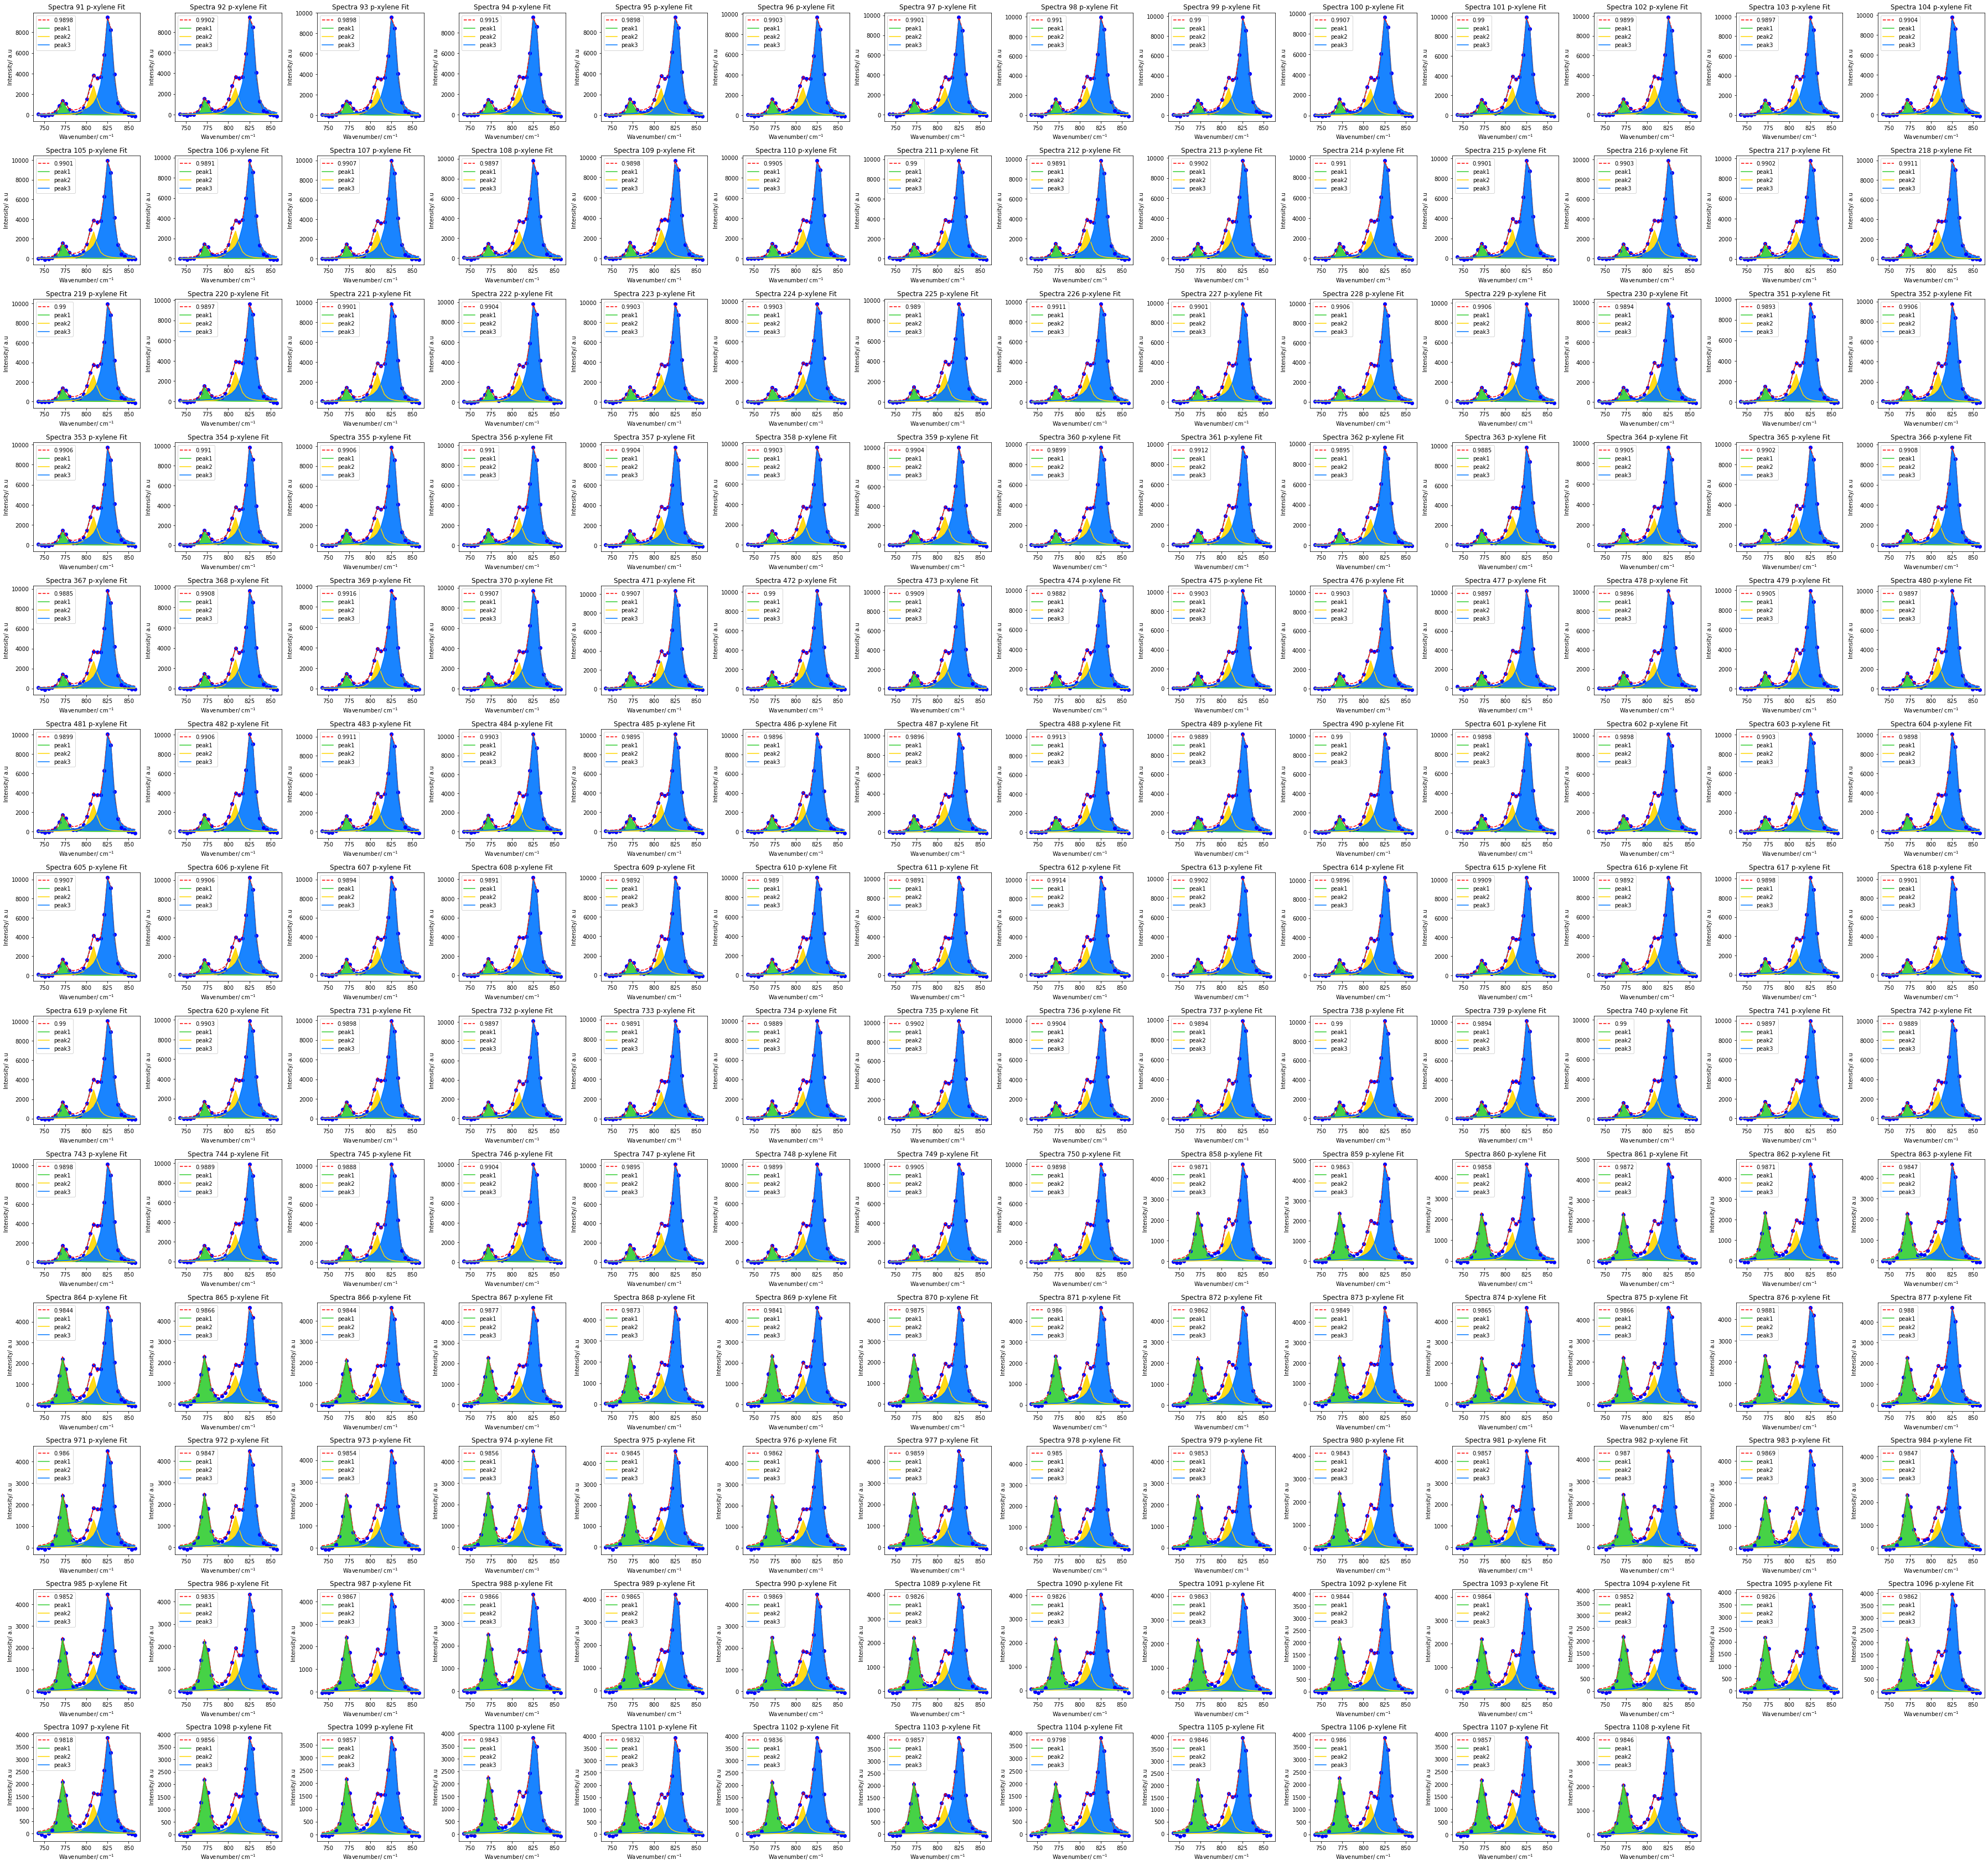

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(int(np.ceil(np.sqrt(df_pxyl.shape[0]))),int(np.ceil(np.sqrt(df_pxyl.shape[0]))),(1+i))
    # int() prior to np.ceil was added because subplots no longer accept any other data type except for int.
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count    180.000000    180.000000     180.000000  180.000000  180.000000   
mean   21746.640833  36511.414783  147668.266162  772.702354  808.291889   
std     7823.418026  11167.042340   48641.235916    0.237949    0.245487   
min    13941.031927  16736.238364   69977.618382  772.241184  807.503948   
25%    15858.255913  22879.366142   84436.581612  772.524387  808.134357   
50%    17341.016247  42622.747094  178792.571186  772.697875  808.294269   
75%    31467.708327  44920.812248  183346.937110  772.871967  808.431068   
max    37195.219295  48839.598383  190945.248333  773.331941  809.021406   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  180.000000  180.000000  180.000000  180.000000  180.000000  180.000000   
mean   827.118412    3.652638    5.064426    6.726544    4.176542    0.988509   
std      0.095133    0.576528    0.250476    0.220270    0.093901    0.002427   
min    826.793242    2.602419    4.462770    5.956744    3.893869    0.979754   
25%    827.059276    3.219385    4.911830    6.580411    4.122041    0.986581   
50%    827.116231    3.444352    5.065976    6.711003    4.171684    0.989686   
75%    827.179922    4.323064    5.208732    6.859068    4.227813    0.990277   
max    827.359873    4.727037    5.886559    7.445738    4.471643    0.991622   

          FWHM_L1     FWHM_L2     FWHM_L3    Height_L1    Height_L2  \
count  180.000000  180.000000  180.000000   180.000000   180.000000   
mean     7.305276   10.128852   10.903087  1846.379048  2300.741484   
std      1.153055    0.500952    0.237277   384.379958   710.631868   
min      5.204839    8.925540   10.087166  1313.114335  1074.549633   
25%      6.438770    9.823661   10.753012  1545.639220  1407.985072   
50%      6.888703   10.131952   10.902396  1688.590422  2738.167238   
75%      8.646129   10.417465   11.029164  2265.845494  2828.414934   
max      9.454073   11.773119   11.564016  2594.736863  2998.091423   

         Height_L3  
count   180.000000  
mean   4316.264616  
std    1429.806158  
min    1989.050525  
25%    2465.806531  
50%    5213.845042  
75%    5391.816284  
max    5539.802063

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                91     C1_R1    138587.547652  0.965637   159754.344114   
1                92     C1_R1    141260.120642  0.967180   164943.660881   
2                93     C1_R1    147813.740481  0.969402   162581.794595   
3                94     C1_R1    142101.268120  0.967807   165921.529950   
4                95     C1_R1    138929.524392  0.966163   169959.135795   
..              ...       ...              ...       ...             ...   
175            1104    C10_R3    187700.592128  0.990751    65899.479727   
176            1105    C10_R3    189697.713225  0.991691    68481.315497   
177            1106    C10_R3    188225.767867  0.991016    65579.022628   
178            1107    C10_R3    187189.265204  0.991182    65783.302522   
179            1108    C10_R3    190395.598963  0.990436    69106.134954   

      R2_pxyl  
0    0.989848  
1    0.990178  
2    0.989754  
3    0.991512  
4    0.989813  
..        ...  
175  0.979754  
176  0.984639  
177  0.986048  
178  0.985685  
179  0.984580  

[180 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.95) & (df_area['R2_pxyl'] > 0.95)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                91     C1_R1    138587.547652  0.965637   159754.344114   
1                92     C1_R1    141260.120642  0.967180   164943.660881   
2                93     C1_R1    147813.740481  0.969402   162581.794595   
3                94     C1_R1    142101.268120  0.967807   165921.529950   
4                95     C1_R1    138929.524392  0.966163   169959.135795   
..              ...       ...              ...       ...             ...   
175            1104    C10_R3    187700.592128  0.990751    65899.479727   
176            1105    C10_R3    189697.713225  0.991691    68481.315497   
177            1106    C10_R3    188225.767867  0.991016    65579.022628   
178            1107    C10_R3    187189.265204  0.991182    65783.302522   
179            1108    C10_R3    190395.598963  0.990436    69106.134954   

      R2_pxyl  Vinyl Divide pxyl  
0    0.989848           0.867504  
1    0.990178           0.856414  
2    0.989754           0.909165  
3    0.991512           0.856437  
4    0.989813           0.817429  
..        ...                ...  
175  0.979754           2.848286  
176  0.984639           2.770065  
177  0.986048           2.870213  
178  0.985685           2.845544  
179  0.984580           2.755119  

[180 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
C10_R1                 20.0  2.497818  0.050011  2.415993  2.459435  2.505058   
C10_R2                 20.0  2.810920  0.056364  2.706386  2.790243  2.810339   
C10_R3                 20.0  2.794369  0.064624  2.671359  2.747438  2.806829   
C19_R1                 20.0  0.892403  0.015199  0.849054  0.891710  0.896870   
C19_R2                 20.0  0.880225  0.013401  0.851560  0.874838  0.880581   
C19_R3                 20.0  0.900092  0.015707  0.879423  0.890769  0.895594   
C1_R1                  20.0  0.838785  0.027156  0.781990  0.825428  0.835729   
C1_R2                  20.0  0.808676  0.018351  0.766202  0.802484  0.808806   
C1_R3                  20.0  0.823516  0.017444  0.794972  0.809589  0.821409   

                               
                75%       max  
Condition                      
C10_R1     2.525232  2.599718  
C10_R2     2.833349  2.933343  
C10_R3     2.846229  2.893979  
C19_R1     0.900585  0.908738  
C19_R2     0.888018  0.903062  
C19_R3     0.908962  0.938748  
C1_R1      0.856420  0.909165  
C1_R2      0.817095  0.842351  
C1_R3      0.836110  0.858141

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = ['10_Repeat', '10_Repeat_2', '10_Repeat_3', '19_Repeat', '19_Repeat_1' , '19_Repeat_2',
             '1_Repeat', '1_Repeat_2', '1_Repeat_3']

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio = df_ratio.reindex([6, 7, 8, 3, 4, 5, 0, 1, 2])
df_ratio = df_ratio.reset_index(drop=True)
df_ratio

Condition  Mean Ratio  Standard Deviation
0     1_Repeat    0.838785            0.027156
1   1_Repeat_2    0.808676            0.018351
2   1_Repeat_3    0.823516            0.017444
3    19_Repeat    0.892403            0.015199
4  19_Repeat_1    0.880225            0.013401
5  19_Repeat_2    0.900092            0.015707
6    10_Repeat    2.497818            0.050011
7  10_Repeat_2    2.810920            0.056364
8  10_Repeat_3    2.794369            0.064624

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\210224 High Throughput Experiment Conditions 1, 19 and 10 Repeat\Raman\df_t120_ratio.csv')